[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)

#### based on Fig. 2 from Yang et al. 2018 (Atmos. Chem. Phys. 18)  "_Cloud droplet size distribution broadening during diffusional growth: ripening amplified by deactivation and reactivation_"   
https://doi.org/10.5194/acp-18-7313-2018

In [1]:
import sys

from matplotlib.pyplot import xlabel

if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from open_atmos_jupyter_utils import show_plot
from PySDM.physics import in_unit, si
from PySDM.physics.constants import PER_CENT
from PySDM_examples.Yang_et_al_2018 import Simulation, Settings

figsize = (9, 6)

In [3]:
ix51 = 40
ix503 = 99

In [4]:
def runner():
    settings = Settings(dt_output=10 * si.minutes)

    assert int(round(in_unit(settings.r_dry[ix51],  si.nm))) == 51
    assert int(round(in_unit(settings.r_dry[ix503], si.nm))) == 503

    output = Simulation(settings).run()
    mass = settings.mass_of_dry_air
    result = {
        'r_bins_edges': settings.r_bins_edges,
        'n': settings.n / mass,
        'dt_max': settings.dt_max,
        'rtol_thd': settings.rtol_thd,
        'rtol_x': settings.rtol_x,
    }
    array_keys = (
        'r_act', 'r_mean_gt_1_um', 'z', 'S', 't', 'T',
        'r_bins_values', 'r'
    )

    result.update({k: output[k] for k in array_keys})
    result['liquid_water_mixing_ratio'] = output["water_vapour_mixing_ratio"][0] - output["water_vapour_mixing_ratio"]
    result['r_bins_values'] = result['r_bins_values'].T / mass
    result['r'] = result['r'].T
    return result


In [5]:
outputs = []
outputs.append(runner())

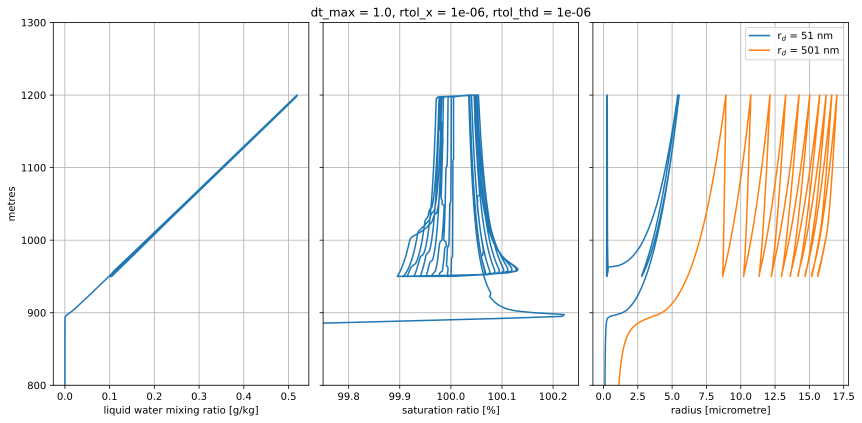

In [6]:
def plot_profiles(outputs, figsize=(12,6)):
    n = len(outputs)
    fig, ax = plt.subplots(n, 3, sharey=True, figsize=figsize)
    if len(outputs)==1:
        ax = np.array(ax).reshape(n,3)
        
    xunit_q = si.gram / si.kilogram
    xunit_S = PER_CENT
    xunit_r = si.um
    
    for i, out in enumerate(outputs):
        z = out['z']
        dt_max = out['dt_max']
        rtol_x = out['rtol_x']
        rtol_thd = out['rtol_thd']
        tols = f'rtol_x = {rtol_x}, rtol_thd = {rtol_thd}'
        
        a = ax[i, 0]
        a.plot(
            in_unit(out['liquid_water_mixing_ratio'], xunit_q),
            z,
        )
        a.grid()
        a.set(
            xlabel='liquid water mixing ratio [g/kg]',
            ylim=[800, 1300],
            ylabel="metres"
        )
    
        a = ax[i, 1]
        a.plot(in_unit(out['S']+1, xunit_S), z)
        a.grid()
        a.set(
            xlabel="saturation ratio [%]",
            xlim=[99.75, 100.25],
            title=f'dt_max = {dt_max}, '+tols
        )
        
        a = ax[i, 2]
        a.plot(
            in_unit(out['r'][ix51], xunit_r),
            z,
            label="r$_d$ = 51 nm"
        )
        a.plot(
            in_unit(out['r'][ix503], xunit_r),
            z,
            label="r$_d$ = 501 nm"
        )
        a.set(xlabel="radius [micrometre]")
        a.grid()
        a.legend()
    
    fig.tight_layout()
    show_plot(filename='q_S_rd.pdf')

plot_profiles(outputs)

Cloud droplet size distribution changes with time. The black line represents the mean cloud droplet radius change with time.

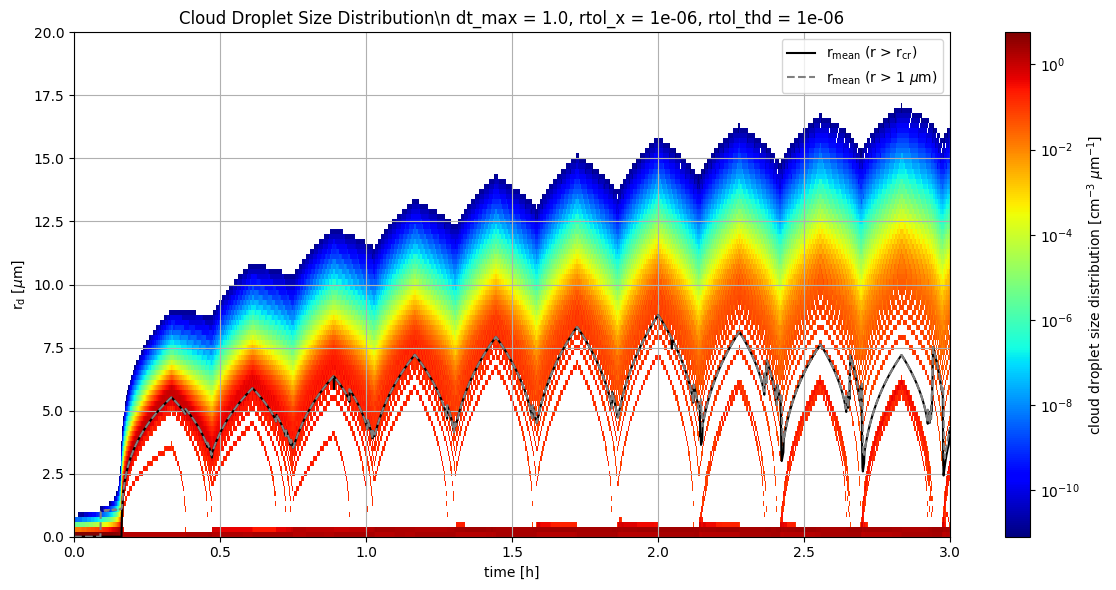

In [7]:
def plot_outputs(outputs, figsize=(12, 6)):
    fig, ax = plt.subplots(len(outputs), 1, sharex=True, figsize=figsize)

    if len(outputs) == 1:
        ax = (ax,)
    xunit, yunit = si.hour, si.micrometres
    for i, (a, out) in enumerate(zip(ax, outputs)):
        # --- Label handling ---
        if i == 2:
            tols = f"tolerance = {out['rtol_bdf']}"
        else:
            tols = f"rtol_x = {out['rtol_x']}, rtol_thd = {out['rtol_thd']}"

        xedges = out['t']
        yedges = out['r_bins_edges']
        hist = in_unit(out['r_bins_values'], si.cm**-3 * si.um**-1)
        hist = 0.5 * (hist[:, :-1] + hist[:, 1:])

        cm = a.pcolormesh(
            in_unit(xedges, xunit),
            in_unit(yedges, yunit),
            hist,
            cmap="jet",
            norm=mpl.colors.LogNorm()
        )
        a.plot(
            in_unit(out['t'], xunit),
            in_unit(out["r_act"], yunit),
            color="black",
            label=r"r$_\text{mean}$ (r > r$_\text{cr}$)"
        )
        a.plot(
            in_unit(out['t'], xunit),
            in_unit(out["r_mean_gt_1_um"], yunit),
            "--",
            color="gray",
            label=r"r$_\text{mean}$ (r > 1 $\mu$m)"
        )
        a.set(
            title=rf"Cloud Droplet Size Distribution\n dt_max = {out['dt_max']}, {tols}",
            ylim=(0,20)
        )
        a.set(
            ylabel=r'r$_\text{d}$ [$\mu$m]',
            xlabel=f'time [h]'
        )
        a.grid()
        a.legend()

    fig.tight_layout()
    fig.colorbar(cm, ax=ax, label=r"cloud droplet size distribution [cm$^{-3}$ $\mu$m$^{-1}$]")
    show_plot(filename='spectrum.pdf', inline_format='png')

plot_outputs(outputs)